In [1]:
import math
import torch
import gpytorch
import spectralgp
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline
torch.manual_seed(0)

#### Set up the GPyTorch Model with Spectral GP kernel
Using the same framework as standard GPyTorch models, we merely drop-in the spectral GP kernel as the covar module

The `initialize_from_data` method does some pre-training on the latent model using the log-periodogram of data as training targets.

For specifics on the components of GPyTorch models we refer to the [GPyTorch Documentation](https://gpytorch.readthedocs.io/en/latest/index.html)

In [2]:
class SpectralModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, latent_lh=None, latent_mod=None, mean=gpytorch.means.ConstantMean, **kwargs):
        super(SpectralModel, self).__init__(train_x, train_y, likelihood)

        self.mean_module = mean()
        self.covar_module = spectralgp.kernels.SpectralGPKernel(**kwargs)
        
        self.covar_module.initialize_from_data(train_x, train_y, latent_lh=latent_lh, latent_mod=latent_mod, **kwargs)
            
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


#### Generate training data and Build GP Model
Generate points in [0, 5] and a sine wave to serve as the response, then split into training and test data.

Pass this data into the GP model from above along with a likelihood

In [3]:
nx = 200
split = 150
full_x = torch.linspace(0, 5, nx)
full_y = torch.sin(2 * full_x)

train_x = full_x[:split]
train_y = full_y[:split]

test_x = full_x[(split - nx):]
test_y = full_y[(split - nx):]

None
None


/home/jayson_s/projects/gpytorch/gpytorch/utils/cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter} to the diagonal", RuntimeWarning)


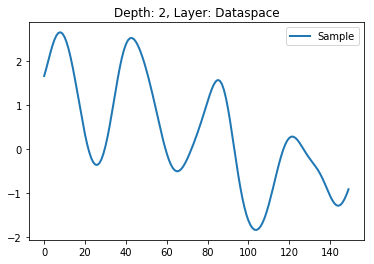

None
None
None


/home/jayson_s/projects/gpytorch/gpytorch/lazy/lazy_tensor.py:1319: UserWarning: Runtime Error when computing Cholesky decomposition: cholesky_cpu: U(8,8) is zero, singular U.. Using RootDecomposition.
  "Runtime Error when computing Cholesky decomposition: {}. Using RootDecomposition.".format(e)


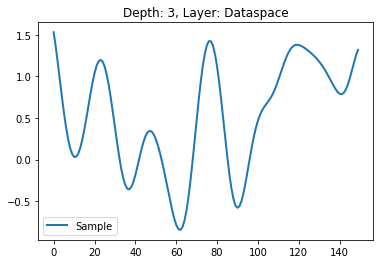

None
None
None
None


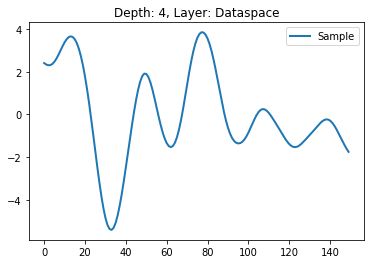

None
None
None
None
None


/home/jayson_s/projects/gpytorch/gpytorch/lazy/lazy_tensor.py:1319: UserWarning: Runtime Error when computing Cholesky decomposition: cholesky_cpu: U(12,12) is zero, singular U.. Using RootDecomposition.
  "Runtime Error when computing Cholesky decomposition: {}. Using RootDecomposition.".format(e)
/home/jayson_s/projects/gpytorch/gpytorch/lazy/lazy_tensor.py:1319: UserWarning: Runtime Error when computing Cholesky decomposition: cholesky_cpu: U(9,9) is zero, singular U.. Using RootDecomposition.
  "Runtime Error when computing Cholesky decomposition: {}. Using RootDecomposition.".format(e)
/home/jayson_s/projects/gpytorch/gpytorch/lazy/lazy_tensor.py:1319: UserWarning: Runtime Error when computing Cholesky decomposition: cholesky_cpu: U(16,16) is zero, singular U.. Using RootDecomposition.
  "Runtime Error when computing Cholesky decomposition: {}. Using RootDecomposition.".format(e)


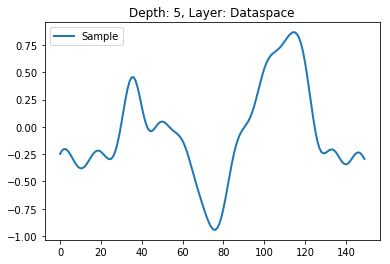

None
None
None
None
None
None


/home/jayson_s/projects/gpytorch/gpytorch/lazy/lazy_tensor.py:1319: UserWarning: Runtime Error when computing Cholesky decomposition: cholesky_cpu: U(13,13) is zero, singular U.. Using RootDecomposition.
  "Runtime Error when computing Cholesky decomposition: {}. Using RootDecomposition.".format(e)


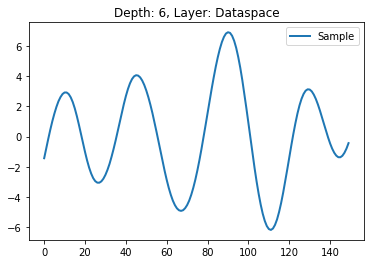

None
None
None
None
None
None
None


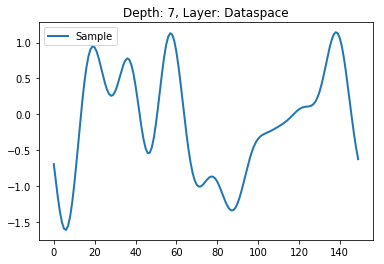

None
None
None
None
None
None
None


/home/jayson_s/projects/gpytorch/gpytorch/lazy/lazy_tensor.py:1319: UserWarning: Runtime Error when computing Cholesky decomposition: cholesky_cpu: U(10,10) is zero, singular U.. Using RootDecomposition.
  "Runtime Error when computing Cholesky decomposition: {}. Using RootDecomposition.".format(e)
/home/jayson_s/projects/gpytorch/gpytorch/lazy/lazy_tensor.py:1319: UserWarning: Runtime Error when computing Cholesky decomposition: cholesky_cpu: U(14,14) is zero, singular U.. Using RootDecomposition.
  "Runtime Error when computing Cholesky decomposition: {}. Using RootDecomposition.".format(e)


None


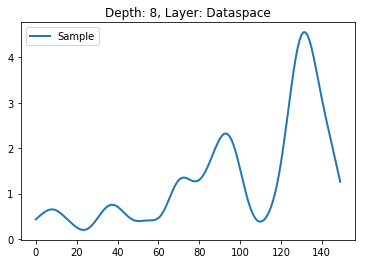

None
None
None
None
None
None
None
None
None


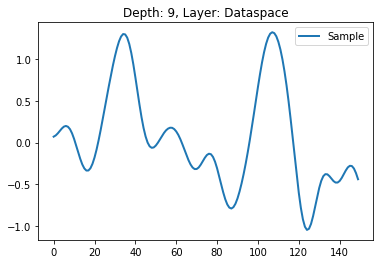

None
None
None
None
None
None
None
None


/home/jayson_s/projects/gpytorch/gpytorch/utils/cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-07 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter} to the diagonal", RuntimeWarning)
/home/jayson_s/projects/gpytorch/gpytorch/lazy/lazy_tensor.py:1319: UserWarning: Runtime Error when computing Cholesky decomposition: cholesky_cpu: U(20,20) is zero, singular U.. Using RootDecomposition.
  "Runtime Error when computing Cholesky decomposition: {}. Using RootDecomposition.".format(e)


None
None


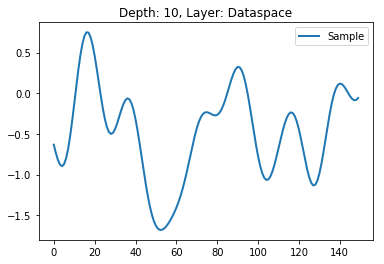

None
None
None
None
None
None
None
None


/home/jayson_s/projects/gpytorch/gpytorch/lazy/lazy_tensor.py:1319: UserWarning: Runtime Error when computing Cholesky decomposition: cholesky_cpu: U(31,31) is zero, singular U.. Using RootDecomposition.
  "Runtime Error when computing Cholesky decomposition: {}. Using RootDecomposition.".format(e)


None
None
None


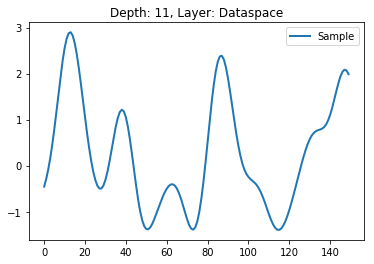

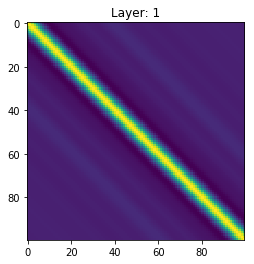

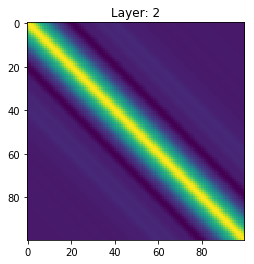

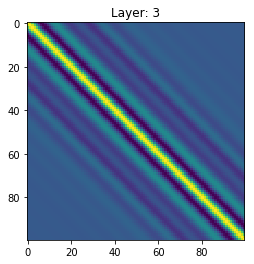

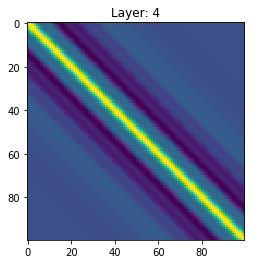

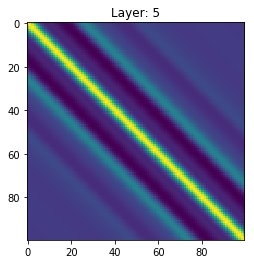

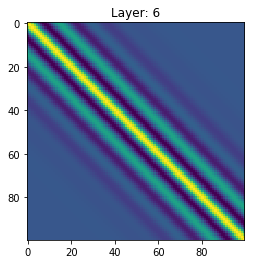

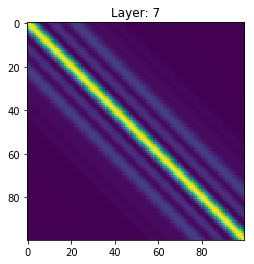

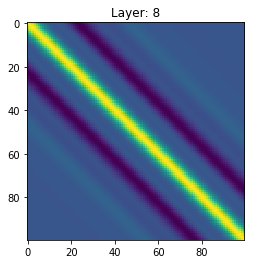

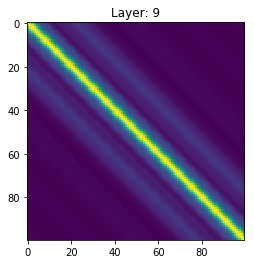

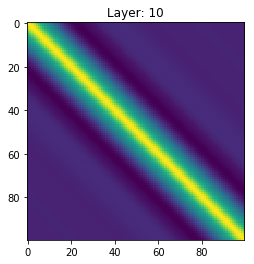

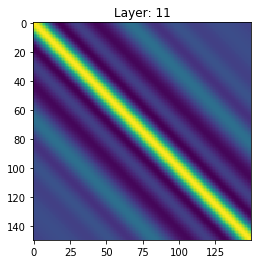

In [4]:
MAX_DEPTH = 10

for depth in range(0,MAX_DEPTH):
    likelihoods = []
    models = []

    likelihoods.append(gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.SmoothedBoxPrior(1e-8, 1e-4)))
    models.append(SpectralModel(train_x, train_y, likelihoods[-1], mean=spectralgp.means.LogRBFMean, nomg=100, pretrain=False))
    
    for i in range(depth):
        likelihoods.append(gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.SmoothedBoxPrior(1e-8, 1e-4)))
        models.append(SpectralModel(train_x, train_y, likelihoods[-1], latent_lh=likelihoods[-2], latent_mod=models[-1], mean=spectralgp.means.LogRBFMean, nomg=100, pretrain=False))
        
        
    likelihoods.append(gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.SmoothedBoxPrior(1e-8, 1e-4)))
    models.append(SpectralModel(train_x, train_y, likelihoods[-1], latent_lh=likelihoods[-2], latent_mod=models[-1], nomg=100, pretrain=False))
        
    Ft = models[-1](*models[-1].train_inputs).sample().detach().numpy()
    plt.plot(Ft,linewidth=2, label="Sample")
    plt.legend()
    plt.title("Depth: {}, Layer: Dataspace".format(2+depth))
    plt.show()

for i in range(len(models)):
    plt.imshow(models[i](*models[i].train_inputs).covariance_matrix.detach().numpy())
    plt.title("Layer: {}".format(i+1))
    plt.show()

#### Set up sampling factories

In the inference procedure we consider fixing the latent GP observation and doing gradient descent updates on the hyperparameters, then fixing the hyperparameters and using elliptical slice sampling to update the latent GP. 

The `ss_factory` generates a "factory" that fixes the latent GP and computes the loss function of the hyperparameters

Set up Alternating Sampler

In [5]:
n_iters = 1
ess_iters = 5
optim_iters = 5

In [6]:
alt_samplers = []
for layers in range(len(models)):
    alt_samplers.append(spectralgp.samplers.AlternatingSampler(
    [models[layers]], [likelihoods[layers]], 
    spectralgp.sampling_factories.ss_factory, [spectralgp.sampling_factories.ess_factory],
    totalSamples=n_iters, numInnerSamples=ess_iters, numOuterSamples=optim_iters
    ))

trials = 10
for t in range(trials):
    for i in reversed(alt_samplers):
        i.run()

Loss is:  tensor(-201.1118, grad_fn=<DivBackward0>)
Loss is:  tensor(-198.3210, grad_fn=<DivBackward0>)
Loss is:  tensor(-195.5707, grad_fn=<DivBackward0>)
Loss is:  tensor(-192.8545, grad_fn=<DivBackward0>)
Loss is:  tensor(-190.1824, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Seconds for Iteration 0 : 5.3015289306640625
Loss is:  tensor(-257.6382, grad_fn=<DivBackward0>)
Loss is:  tensor(-254.0468, grad_fn=<DivBackward0>)
Loss is:  tensor(-250.4934, grad_fn=<DivBackward0>)
Loss is:  tensor(-246.9886, grad_fn=<DivBackward0>)
Loss is:  tensor(-243.5329, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Seconds for Iteration 0 : 3.2094640731811523
Loss is:  tensor(-218.2587, grad_fn=<DivBackward0>)
Loss is:  tensor(-215.1926, grad_fn=<DivBackward0>)
Loss is:  tensor(-212.1553, grad_fn=<DivBackward0>)
Loss is:  tensor(-209.1616, grad_fn=<DivBackward0>)
Loss is:  tensor(-206.2123, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Seconds for Iteration 0 : 1.7619280815124512
Loss is:  tensor(-1

Loss is:  tensor(-62.6713, grad_fn=<DivBackward0>)
Loss is:  tensor(-61.8156, grad_fn=<DivBackward0>)
Loss is:  tensor(-60.9795, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Seconds for Iteration 0 : 1.340362787246704
Loss is:  tensor(-49.1931, grad_fn=<DivBackward0>)
Loss is:  tensor(-48.5383, grad_fn=<DivBackward0>)
Loss is:  tensor(-47.8819, grad_fn=<DivBackward0>)
Loss is:  tensor(-47.2417, grad_fn=<DivBackward0>)
Loss is:  tensor(-46.6175, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Seconds for Iteration 0 : 0.8174378871917725
Loss is:  tensor(-37.2002, grad_fn=<DivBackward0>)
Loss is:  tensor(-36.7208, grad_fn=<DivBackward0>)
Loss is:  tensor(-36.2371, grad_fn=<DivBackward0>)
Loss is:  tensor(-35.7668, grad_fn=<DivBackward0>)
Loss is:  tensor(-35.3099, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Seconds for Iteration 0 : 0.5781123638153076
Loss is:  tensor(-27.6190, grad_fn=<DivBackward0>)
Loss is:  tensor(-27.2751, grad_fn=<DivBackward0>)
Loss is:  tensor(-26.9267, grad_fn=

Loss is:  tensor(-7.4659, grad_fn=<DivBackward0>)
Loss is:  tensor(-7.4322, grad_fn=<DivBackward0>)
Loss is:  tensor(-7.3913, grad_fn=<DivBackward0>)
Loss is:  tensor(-7.3541, grad_fn=<DivBackward0>)
Loss is:  tensor(-7.3221, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Seconds for Iteration 0 : 0.3813142776489258
Loss is:  tensor(-5.3181, grad_fn=<DivBackward0>)
Loss is:  tensor(-5.3024, grad_fn=<DivBackward0>)
Loss is:  tensor(-5.2796, grad_fn=<DivBackward0>)
Loss is:  tensor(-5.2598, grad_fn=<DivBackward0>)
Loss is:  tensor(-5.2447, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Seconds for Iteration 0 : 0.3036916255950928
Loss is:  tensor(-3.6967, grad_fn=<DivBackward0>)
Loss is:  tensor(-3.6913, grad_fn=<DivBackward0>)
Loss is:  tensor(-3.6811, grad_fn=<DivBackward0>)
Loss is:  tensor(-3.6734, grad_fn=<DivBackward0>)
Loss is:  tensor(-3.6684, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Seconds for Iteration 0 : 0.23758411407470703
Loss is:  tensor(-2.0832, grad_fn=<DivBackward0>

Seconds for Iteration 0 : 0.14602065086364746
Loss is:  tensor(-28.7300, grad_fn=<DivBackward0>)
Loss is:  tensor(-28.3629, grad_fn=<DivBackward0>)
Loss is:  tensor(-28.0105, grad_fn=<DivBackward0>)
Loss is:  tensor(-27.6696, grad_fn=<DivBackward0>)
Loss is:  tensor(-27.3385, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Seconds for Iteration 0 : 5.031054973602295
Loss is:  tensor(-26.3144, grad_fn=<DivBackward0>)
Loss is:  tensor(-26.0373, grad_fn=<DivBackward0>)
Loss is:  tensor(-25.7637, grad_fn=<DivBackward0>)
Loss is:  tensor(-25.4993, grad_fn=<DivBackward0>)
Loss is:  tensor(-25.2425, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Seconds for Iteration 0 : 2.83874249458313
Loss is:  tensor(-16.7038, grad_fn=<DivBackward0>)
Loss is:  tensor(-16.5768, grad_fn=<DivBackward0>)
Loss is:  tensor(-16.4344, grad_fn=<DivBackward0>)
Loss is:  tensor(-16.3037, grad_fn=<DivBackward0>)
Loss is:  tensor(-16.1815, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Seconds for Iteration 0 : 1.79041409

Loss is:  tensor(-7.0614, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Seconds for Iteration 0 : 1.3073532581329346
Loss is:  tensor(-5.3075, grad_fn=<DivBackward0>)
Loss is:  tensor(-5.3107, grad_fn=<DivBackward0>)
Loss is:  tensor(-5.2881, grad_fn=<DivBackward0>)
Loss is:  tensor(-5.2744, grad_fn=<DivBackward0>)
Loss is:  tensor(-5.2746, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Seconds for Iteration 0 : 0.829174280166626
Loss is:  tensor(-4.1408, grad_fn=<DivBackward0>)
Loss is:  tensor(-4.1514, grad_fn=<DivBackward0>)
Loss is:  tensor(-4.1363, grad_fn=<DivBackward0>)
Loss is:  tensor(-4.1301, grad_fn=<DivBackward0>)
Loss is:  tensor(-4.1369, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Seconds for Iteration 0 : 0.533228874206543
Loss is:  tensor(-3.3143, grad_fn=<DivBackward0>)
Loss is:  tensor(-3.3248, grad_fn=<DivBackward0>)
Loss is:  tensor(-3.3129, grad_fn=<DivBackward0>)
Loss is:  tensor(-3.3084, grad_fn=<DivBackward0>)
Loss is:  tensor(-3.3152, grad_fn=<DivBackward0>)
T

#### Process the outputs
The alternating sampler provides a good set of hyperparamters (already attached to the model) and samples of the spectral density of the covariance function.

To generate predictions we look at the last samples of the alterntating sampler and generate covariance functions from each of these samples. 

In the below plotting we show 10 predictions: one prediction for each of the last 10 sampled log-spectral densities taken from the alternating sampler.

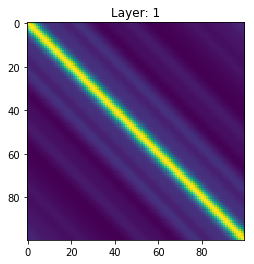

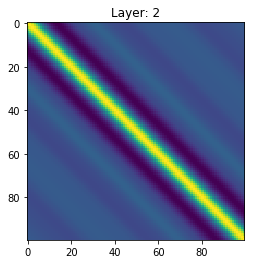

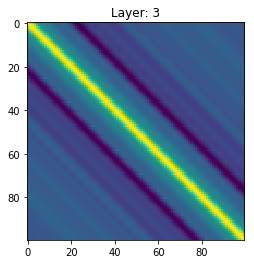

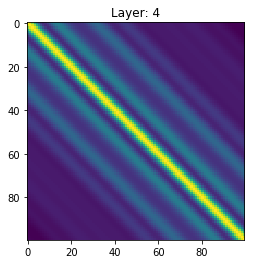

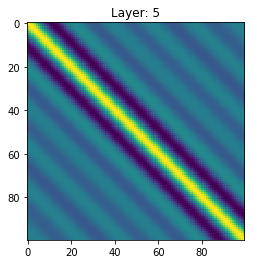

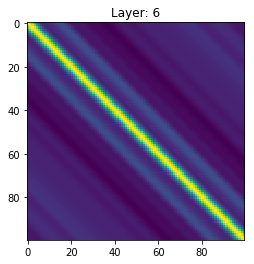

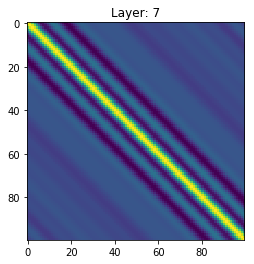

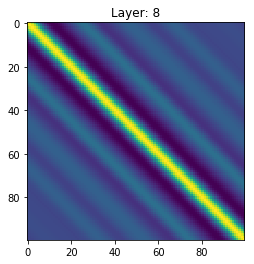

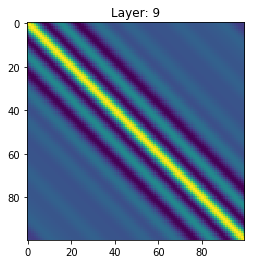

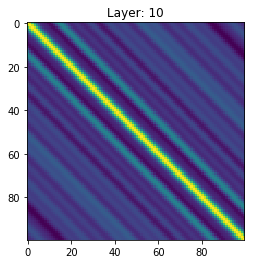

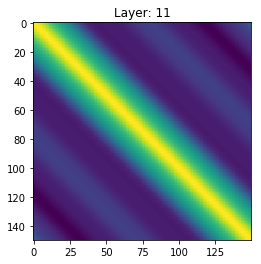

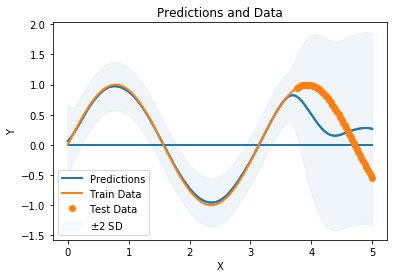

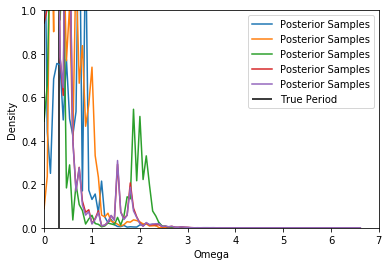

In [7]:
for i in range(len(models)):
    plt.imshow(models[i](*models[i].train_inputs).covariance_matrix.detach().numpy())
    plt.title("Layer: {}".format(i+1))
    plt.show()
    
    
    
models[-1].eval()
n_samples = 1
spectrum_samples = alt_samplers[-1].gsampled[0][0,:, -10:].detach()

predictions = torch.zeros(len(full_x), 10) # predictions for each sample
upper_bds = torch.zeros(len(full_x), 10) # upper conf. bd for each sample
lower_bds = torch.zeros(len(full_x), 10) # lower conf. bd for each sample

with torch.no_grad():
    for ii in range(n_samples):
        models[-1].covar_module.set_latent_params(spectrum_samples[:, ii])
        models[-1].set_train_data(train_x, train_y) # to clear out the cache
        pred_dist = models[-1](full_x) 
        lower_bds[:, ii], upper_bds[:, ii] = pred_dist.confidence_region()
        predictions[:, ii] = pred_dist.mean


colors = cm.get_cmap("tab10")
## plot the predictions ##
plt.plot(full_x.numpy(), predictions[:, 0].detach().numpy(), label="Predictions",
         color=colors(0), linewidth=2)
plt.plot(full_x.numpy(), predictions.detach().numpy(), linewidth=2, 
         color=colors(0))

## Shade region +/- 2 SD around the mean ##
plt.fill_between(full_x.numpy(), lower_bds[:, 0].detach().numpy(), 
                 upper_bds[:, 0].detach().numpy(),
                 color=colors(0), alpha=0.03, label = r"$\pm 2$ SD")
for ii in range(n_samples):
    plt.fill_between(full_x.numpy(), lower_bds[:, ii].detach().numpy(), 
                     upper_bds[:, ii].detach().numpy(), 
                     color=colors(0), alpha=0.03)
    
## plot data ##
plt.plot(train_x.numpy(), train_y.numpy(), color=colors(1),
        linewidth=2, label="Train Data")
plt.plot(test_x.numpy(), test_y.numpy(), color=colors(1),
        linestyle="None", marker=".", markersize=12,
        label="Test Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Predictions and Data")
plt.legend()
plt.show()

plt.plot(models[-1].covar_module.omega.numpy(), spectrum_samples.exp().numpy(), label = 'Posterior Samples')
plt.xlabel('Omega')
plt.ylabel('Density')
plt.xlim((0, 7))
plt.ylim((0,1))
plt.vlines(2/(2*3.14159),ymin=0, ymax=10, label = 'True Period')
plt.legend()


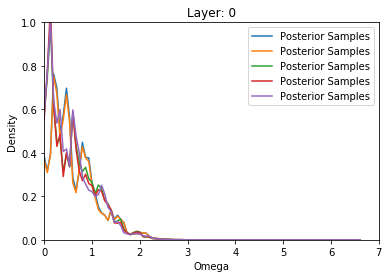

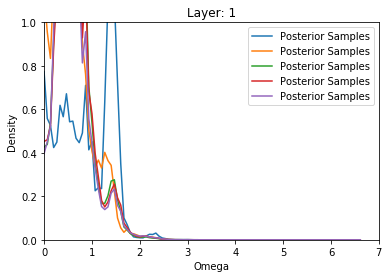

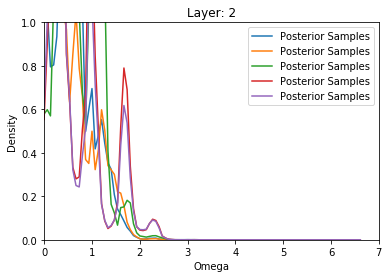

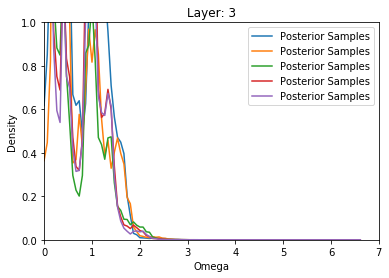

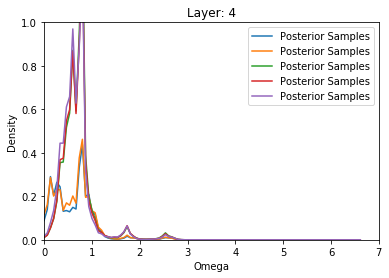

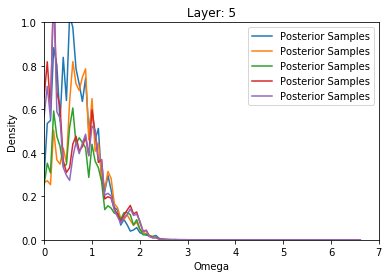

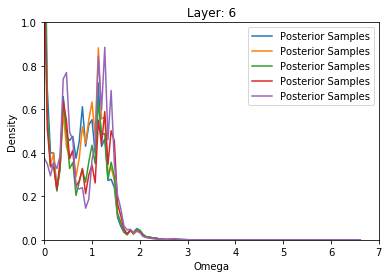

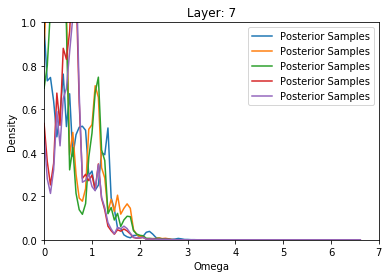

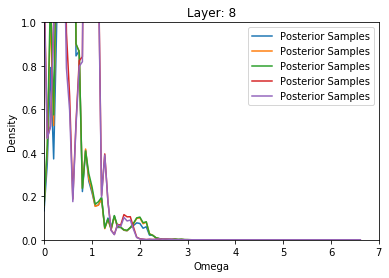

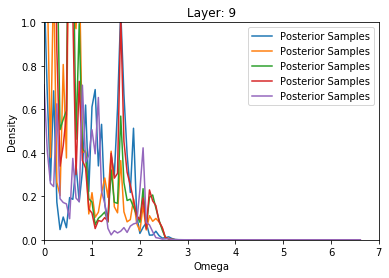

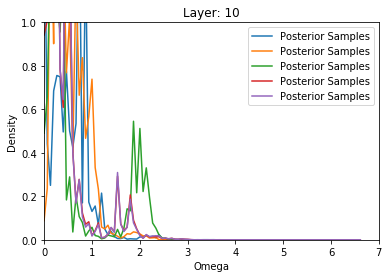

In [8]:
for idx, i in enumerate(reversed(models)):
    i.eval()
    n_samples = 1
    spectrum_samples = alt_samplers[idx].gsampled[0][0,:, -10:].detach()


    plt.plot(i.covar_module.omega.numpy(), spectrum_samples.exp().numpy(), label = 'Posterior Samples')
    plt.xlabel('Omega')
    plt.ylabel('Density')
    plt.title("Layer: {}".format(idx))
    plt.xlim((0, 7))
    plt.ylim((0,1))
    plt.legend()
    plt.show()

In [9]:
import numpy as np
print(np.trapz(spectrum_samples.exp().t().numpy(), model.covar_module.omega.numpy()))

NameError: name 'model' is not defined